In [1]:
import pickle
import numpy as np
import math
import cv2
from PIL import Image
import os
import time
import argparse
import matplotlib.pyplot as plt

In [105]:
pointsToSample = 10

map_struct = pickle.load(open("../map_generation/map.pickle", "rb"))
map_occupied = map_struct['map']  # Binary map
map_rgb = np.stack([(map_occupied == 0) * 255 for i in range(3)],
                   axis=-1).astype(np.uint8)  # Black White 3 channel image
lengthPerPixel = map_struct['dimensions'][
    'lengthPerPixel']  # Conversion from pixel to meters in unreal
top_start, left_start = map_struct['start']['top'], map_struct['start'][
    'left']  # Start position of the dron
top_lim, left_lim = map_occupied.shape

In [166]:
0.2/lengthPerPixel

25.300453458418787

In [3]:
map_occupied.shape

(958, 1220)

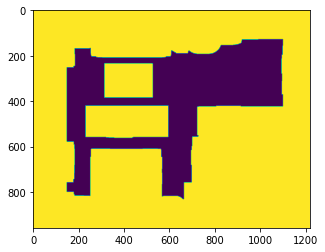

In [83]:
plt.imshow(map_occupied)

In [106]:
nx, ny = (50, 50)
x = np.linspace(0, top_lim-1, nx)
y = np.linspace(0, left_lim-1, ny)
xv, yv = np.meshgrid(x, y)
# sample points
points = np.floor(np.stack([xv.reshape(-1),yv.reshape(-1)]).T).astype(int) # top, left

In [178]:
# Compute distance transform
from scipy.ndimage.morphology import distance_transform_edt as bwdist
from scipy.ndimage.morphology import binary_erosion,binary_dilation
from scipy.ndimage import generate_binary_structure


In [81]:
struct2 = generate_binary_structure(10, 10)

In [179]:
m = map_occupied.copy()

In [110]:
    
m2 = binary_dilation(map_occupied, np.ones([50,50]))

In [187]:
valid_points = []
for p in points:
    if not m2[p[0], p[1]]:
        valid_points.append((p[0],p[1]))

In [190]:
valid_points_filtered = []
for p in valid_points:
    f = False
    for p2 in valid_points_filtered:
        if(0 < math.sqrt((p2[0] -p[0])**2 + (p2[1]-p[1])**2) < 100):
            f = True
    if not f:
        valid_points_filtered.append(p)

In [183]:
m = map_rgb.copy()

In [184]:
for p in valid_points:
    m[p[0]-3:p[0]+3,p[1]-3:p[1]+3,:] = np.asarray([255,0,0])

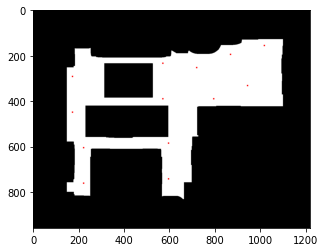

In [185]:
plt.imshow(m)

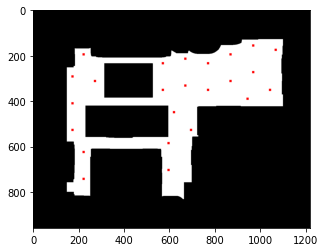

In [191]:
m = map_rgb.copy()
for p in valid_points_filtered:
    m[p[0]-5:p[0]+5,p[1]-5:p[1]+5,:] = np.asarray([255,0,0])
plt.imshow(m)

In [192]:
valid_points = valid_points_filtered

In [193]:
from rrt import RRTStar

In [194]:
distances = []
t = time.time()
for i in range(len(valid_points)):
    t1 = time.time()
    print(str(i) + "/" + str(len(valid_points)))
    for j in range(len(valid_points)):
        if i ==j:
            continue
        start = (valid_points[i][0], valid_points[i][1])
        goal =  (valid_points[j][0] , valid_points[j][1])
        rrt = RRTStar(
            start=start,
            goal=goal,
            rand_area=[0, 1200],
            obstacle_list= map_occupied, max_iter = 1000)
        route = np.asarray(rrt.planning(animation=False))
        try:
            length = np.sum(np.sum(np.diff(route.T)**2,axis = 0))
            distances.append((i,j, length))
            if(route.shape[0] == 10000):
                print("ERRR!")
                print(start, goal)
        except:
            print(route)
    print("took me " + str((time.time() - t1)/60) + "min")
    t1 = time.time()

0/24
took me 0.2317231774330139min
1/24
took me 0.2424566427866618min
2/24
took me 0.2280939777692159min
3/24
took me 0.23667877515157063min
4/24
took me 0.22419270277023315min
5/24
took me 0.21394580602645874min
6/24
took me 0.2324344277381897min
7/24
None
took me 0.23070233662923176min
8/24
took me 0.23059327205022176min
9/24
took me 0.23528176148732502min
10/24
took me 0.22362072865168253min
11/24
took me 0.2371412992477417min
12/24
None
took me 0.22970696687698364min
13/24
took me 0.2111082673072815min
14/24
took me 0.22846767505009968min
15/24
took me 0.24083513418833416min
16/24
took me 0.23960606257120767min
17/24
took me 0.23819888432820638min
18/24
took me 0.24669727087020873min
19/24
took me 0.23579752047856647min
20/24
took me 0.2293338934580485min
21/24
took me 0.2421363353729248min
22/24
took me 0.23861057360967min
23/24
took me 0.22523998419443766min


In [81]:
with open(r"trajectory.pickle", "wb") as output_file:
    pickle.dump(np.asarray(final_pts).astype(int), output_file)

In [147]:
len(valid_points)

13

In [195]:
import numpy as np
from python_tsp.exact import solve_tsp_dynamic_programming

distance_matrix = np.zeros([len(valid_points),len(valid_points)])

In [ ]:
distance_matrix = np.zeros()

In [196]:
for p in distances:
    distance_matrix[p[0],p[1]] = p[2]

In [ ]:

permutation, distance = solve_tsp_dynamic_programming(distance_matrix)

In [157]:
permutation

[0, 1, 3, 2, 6, 7, 5, 9, 11, 12, 10, 8, 4]

In [158]:
distance

99802.03562206439

In [24]:
with open(r"dist.pickle", "wb") as output_file:
    pickle.dump(distances, output_file)

In [124]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

# 647183
# 647327
# 489471

# The best state found is:  [21 12  8 11 13 14 10 24 23 20 22 17 16  4  0 19  6  1  3  2  7  9 18 15
#   5]
# The fitness at the best state is:  277092


In [125]:
fitness_dists = mlrose.TravellingSales(distances = distances)

In [128]:
min_val = 2259877
best = [ 3 , 1 , 5 , 6 ,14 ,13 ,12 ,22 ,21 ,18 ,24 , 9 ,10 , 8 ,17 ,20 ,15 ,23 , 7 , 0 , 4 ,11 ,19 ,16, 2]

In [129]:
for i in range(5,20):
    best_state, best_fitness = mlrose.genetic_alg(mlrose.TSPOpt(length = len(valid_points), fitness_fn = fitness_dists, maximize=False), max_attempts = 50, random_state = i)
    print( int(best_fitness))
    if (best_fitness < min_val):
        min_val = best_fitness
        best = best_state


124622
130331
135785
134495
134200
136268
127362
135893
137685
126746
122257
127595
136249
141127
125348


In [130]:
best_state = best

In [70]:
c = best_state[7:]
c.extend(best_state[:7])
best_state = c

In [67]:
best_state[:7]

[3, 1, 5, 6, 14, 13, 12]

In [68]:
best_state[7:]

[22, 21, 18, 24, 9, 10, 8, 17, 20, 15, 23, 7, 0, 4, 11, 19, 16, 2]

In [58]:
s = [valid_points[p] for p in best_state]

In [63]:
s[7:]

[(136, 1031),
 (410, 937),
 (410, 843),
 (410, 1031),
 (410, 562),
 (273, 656),
 (273, 562),
 (273, 843),
 (273, 937),
 (273, 750),
 (273, 1031),
 (410, 468),
 (273, 187),
 (273, 281),
 (410, 656),
 (136, 937),
 (410, 750),
 (546, 187)]

In [159]:
best_state = permutation

In [160]:
print('The best state found is: ', best_state)

The best state found is:  [0, 1, 3, 2, 6, 7, 5, 9, 11, 12, 10, 8, 4]


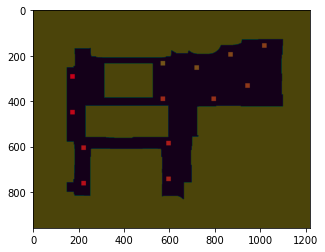

In [161]:

f2 = np.stack([0*map_occupied,map_occupied*0,map_occupied*0], axis = -1)
c = 0
cnt = 0
for j in best_state:
    p = np.asarray(valid_points[j]).astype(int)
    f2[p[0]-10:p[0]+10, p[1]-10:p[1]+10,:] = np.asarray([255-c*10,c*10,0])
    c += 1
    if c == 100:
        break
plt.imshow(f2)
plt.imshow(map_occupied, alpha = 0.3)
plt.show()

In [52]:
valid_points[1]

(410, 187)

In [164]:
start = None
goal = None
all_pts = []
all_pts_state = best_state
all_pts_state.append(best_state[-1])
for p in all_pts_state:
    p = valid_points[p]
    goal = p
    if start is None:
        start = p
        continue
    all_pts.append((start, goal))
    start = p

In [177]:
pickle.dump(np.asarray(final_pts).astype(int), open("trajectory.pickle", "wb"))

(292, 174)  ->  (449, 174)


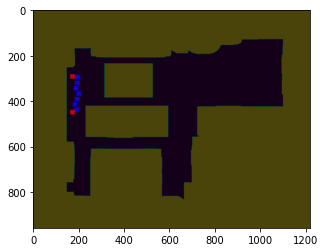

(449, 174)  ->  (761, 223)


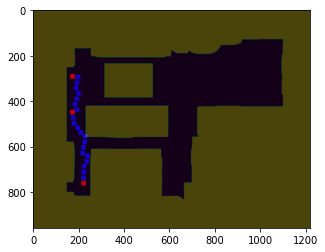

(761, 223)  ->  (605, 223)


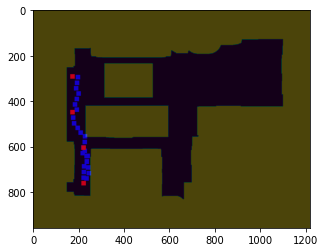

(605, 223)  ->  (585, 597)


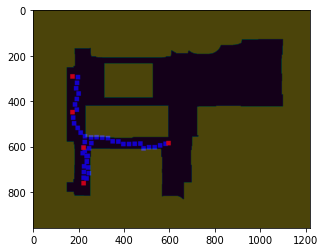

(585, 597)  ->  (742, 597)


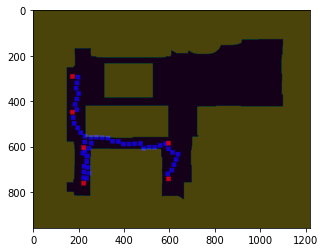

(742, 597)  ->  (390, 572)


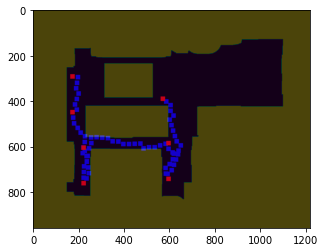

(390, 572)  ->  (390, 796)


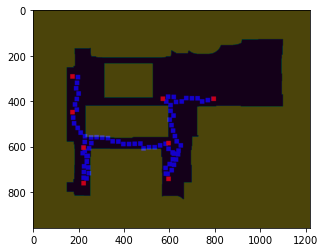

(390, 796)  ->  (332, 945)


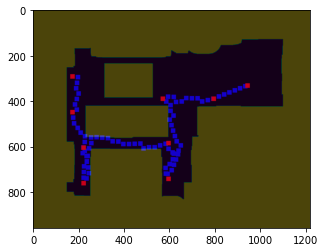

(332, 945)  ->  (156, 1019)


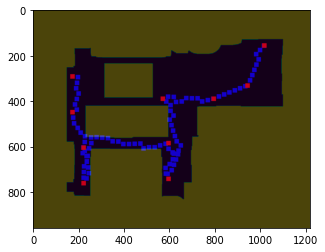

(156, 1019)  ->  (195, 870)


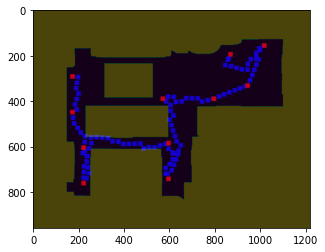

(195, 870)  ->  (253, 721)


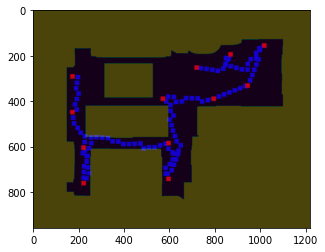

(253, 721)  ->  (234, 572)


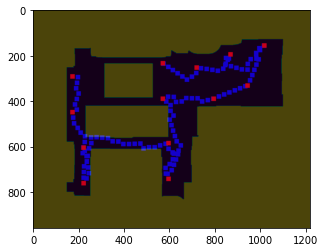

(234, 572)  ->  (234, 572)


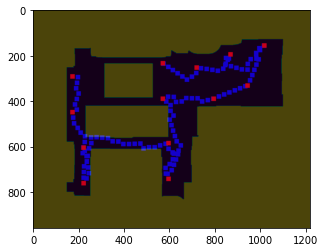

In [167]:
f2 = np.stack([0*map_occupied,map_occupied*0,map_occupied*0], axis = -1)
final_pts = []
cnt = 0
for start, goal in all_pts:
    if cnt == 100:
        break
    print(start, " -> ", goal)
    cnt += 1

    rrt = RRTStar(
            start=start,
            goal=goal,
            rand_area=[0, 1200],expand_dis = 25,
            obstacle_list= map_occupied, max_iter = 5000)
    route = np.asarray(rrt.planning(animation=False))
    route = np.flip(route, axis = 0)
    for p in route:
        final_pts.append(p)
        p = p.astype(int)
        f2[p[0]-10:p[0]+10, p[1]-10:p[1]+10] = np.asarray([0,0,255])

        f2[start[0]-10:start[0]+10, start[1]-10:start[1]+10,:] = np.asarray([255,0,0])
        f2[goal[0]-10:goal[0]+10, goal[1]-10:goal[1]+10,:] = np.asarray([255,0,0])
    plt.imshow(f2)
    plt.imshow(map_occupied, alpha = 0.3)
    plt.show()



In [83]:
f2.shape

(958, 1220, 3)

In [79]:
p[0]

136.0

1/37
2/37
reached max iteration
connectimng (212, 304) and (425, 228)
3/37
reached max iteration
connectimng (425, 228) and (319, 533)
4/37
reached max iteration
connectimng (319, 533) and (744, 685)
5/37
reached max iteration
connectimng (744, 685) and (425, 609)
6/37
reached max iteration
connectimng (425, 609) and (319, 152)
7/37
reached max iteration
connectimng (319, 152) and (212, 228)
8/37
reached max iteration
connectimng (212, 228) and (744, 609)
9/37
reached max iteration
connectimng (744, 609) and (638, 685)
10/37
reached max iteration
connectimng (638, 685) and (319, 838)
11/37
reached max iteration
connectimng (319, 838) and (319, 1066)
12/37
reached max iteration
connectimng (319, 1066) and (425, 685)
13/37
reached max iteration
connectimng (425, 685) and (212, 533)
14/37
reached max iteration
connectimng (212, 533) and (531, 685)
15/37
reached max iteration
connectimng (531, 685) and (531, 609)
16/37
reached max iteration
connectimng (531, 609) and (212, 609)
17/37
reach

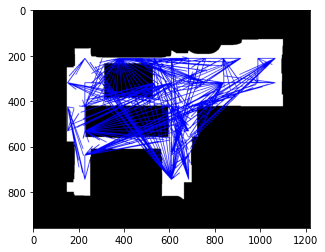

In [134]:
last = None
cnt = 0
for p in best_state:
    cnt += 1
    print("{}/{}".format(cnt, len(best_state)))
    current = valid_points[p]
    if last is None:
        last = current
        continue
    start = last
    goal = current

    rrt = RRTStar(
            start=start,
            goal=goal,
            rand_area=[0, 1200],
            obstacle_list= map_occupied, max_iter = 1000)
    route = np.asarray(rrt.planning(animation=False))
        
    last_pt = None
    cv2.line(map_rgb, (last[1],last[0]), (current[1],current[0]), (0,0,255),2)
    
    print("connectimng {} and {}".format(start,goal))
    for pt in route:
        if last_pt is None:
            last_pt = pt.astype(int)
            continue
        pt = pt.astype(int)
        #         print(".", end="")
        cv2.line(map_rgb, (last_pt[1],last_pt[0]), (pt[1],pt[0]), (0,0,255),2)
    #print("going from " + str(last) + " to " + str(current))
    last = current
plt.imshow(map_rgb)

In [4]:
testsetFolder = "/home/rene/thesis/test_data/"
checkpoint = "/home/rene/catkin_ws/src/active_learning_for_segmentation/embodied_active_learning/refinenet/checkpoints/checkpoint.pth.tar"
network = "refinenet_101"
if network == "refinenet_101":
    network = rf_lw50(40, pretrained = True)
elif network == "refinenet_50":
    network = rf_lw101(40, pretrained = True)
elif network == "refinenet_152":
    network = rf_lw152(40, pretrained = True)
else:
    print("network {} not found!".format(args.network))
    exit()

network = torch.nn.DataParallel(network)
if checkpoint is not None:
    print("Restoring from checkpoint, Path: ", checkpoint)
    network.load_state_dict(torch.load(checkpoint)['model'])
    print("Successfully loaded network")
network.eval()

nyuMappingsYaml = "/home/rene/catkin_ws/src/active_learning_for_segmentation/embodied_active_learning/cfg/airsim/semanticClasses.yaml"
airSimSemanticsConverter = semantics.AirSimSemanticsConverter(nyuMappingsYaml)

IMG_MEAN = torch.tensor(np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1)))
IMG_STD = torch.tensor(np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1)))
transform =   transforms.Compose([pytorch_utils.Transforms.Normalize(IMG_MEAN, IMG_STD), pytorch_utils.Transforms.AsFloat()])
testLoader =  data.DataLoader(pytorch_utils.DataLoader.DataLoaderSegmentation(testsetFolder, transform = transform), batch_size = 8)


Restoring from checkpoint, Path:  /home/rene/catkin_ws/src/active_learning_for_segmentation/embodied_active_learning/refinenet/checkpoints/checkpoint.pth.tar
Successfully loaded network


In [19]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scoring batch 1/13
Scoring batch 4/13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scoring batch 7/13
Scoring batch 10/13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scoring batch 13/13
Scoring batch 16/13
Scoring batch 19/13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scoring batch 22/13
Scoring batch 25/13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scoring batch 28/13
Scoring batch 31/13
Scoring batch 34/13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Scoring batch 37/13


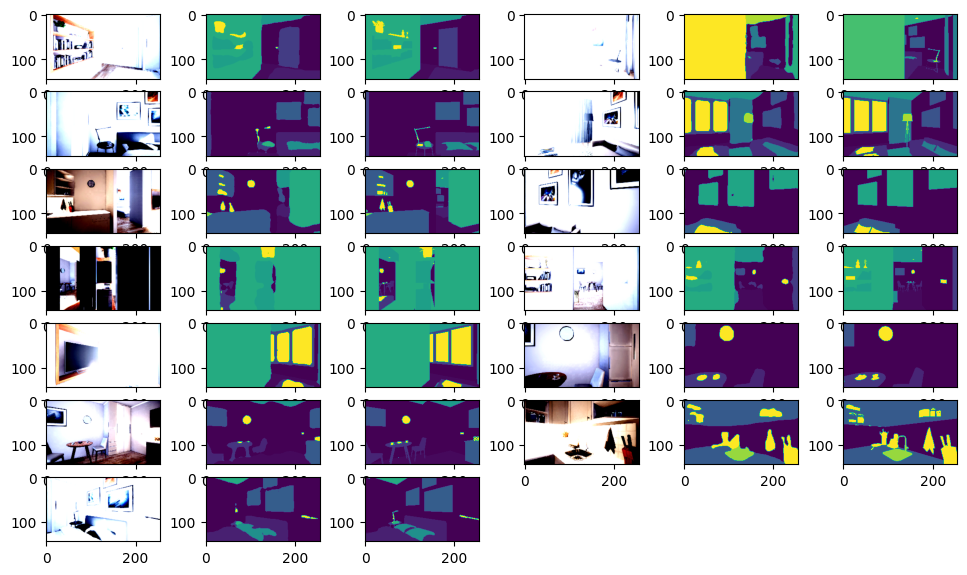

In [22]:
cnt = 0
rows = 8
cols = 3*2
for batch in testLoader:
    cnt += 1
    imgs = batch['image']
    masks = batch['mask']
    h,w = masks.shape[-2:]
    with torch.no_grad():
        print("Scoring batch {}/{}".format(cnt, batches) )
        predictions = network(imgs)
        predictions = F.interpolate(predictions, (h,w), mode = "bilinear", align_corners = False)
        predictions_categorical = torch.argmax(predictions, dim = -3)
        plt.subplot(rows,cols,cnt)
        plt.imshow(imgs.cpu().detach()[0,:,:,:].numpy().transpose(1,2,0))
        cnt += 1
        plt.subplot(rows,cols,cnt)
        plt.imshow(predictions_categorical.cpu().detach().numpy()[0,:,:])
        cnt += 1
        plt.subplot(rows,cols,cnt)
        plt.imshow(masks.cpu().detach().numpy()[0,:,:])

In [5]:
confusion = torch.zeros(40,40)

if torch.cuda.is_available():
    confusion = confusion.cuda()

batches = len(testLoader)
cnt = 0

for batch in testLoader:
    cnt += 1
    imgs = batch['image']
    masks = batch['mask']
    h,w = masks.shape[-2:]
    with torch.no_grad():
        print("Scoring batch {}/{}".format(cnt, batches) )
        predictions = network(imgs)
        predictions = F.interpolate(predictions, (h,w), mode = "bilinear", align_corners = False)
        predictions_categorical = torch.argmax(predictions, dim = -3)
        confusion_matrix = pytorch_utils.semseg_compute_confusion(predictions_categorical, masks, num_classes = 40, ignore_label = None)
        confusion += confusion_matrix

mIoU, classIoU, unseenClasses =  pytorch_utils.semseg_accum_confusion_to_iou(confusion, ignoreZero = True)

print("IoU per Classes:")
for idx, IoU in enumerate(classIoU.cpu().detach().numpy()):
    print("  {:<15}:{:.1f}%".format(airSimSemanticsConverter.getNyuNameForNyuId(idx), IoU))
print("mIoU:")
print("  {:.1f}%".format(mIoU.cpu().detach().numpy().item()))

Scoring batch 1/13
Scoring batch 2/13
Scoring batch 3/13
Scoring batch 4/13
Scoring batch 5/13
Scoring batch 6/13
Scoring batch 7/13
Scoring batch 8/13
Scoring batch 9/13
Scoring batch 10/13
Scoring batch 11/13
Scoring batch 12/13
Scoring batch 13/13
IoU per Classes:
  wall           :94.9%
  floor          :87.9%
  cabinet        :0.0%
  bed            :88.8%
  chair          :74.8%
  sofa           :87.9%
  table          :65.1%
  door           :94.0%
  window         :83.7%
  bookshelf      :0.0%
  picture        :92.5%
  counter        :93.3%
  blinds         :0.0%
  unknown id 13  :0.0%
  shelves        :0.0%
  curtain        :91.9%
  dresser        :0.0%
  pillow         :71.4%
  mirror         :0.0%
  floor mat      :84.7%
  clothes        :0.0%
  ceiling        :94.2%
  books          :80.6%
  refridgerator  :0.0%
  television     :97.5%
  paper          :0.0%
  towel          :0.0%
  shower curtain :0.0%
  box            :0.0%
  whiteboard     :0.0%
  person         :0.0%
  n

In [ ]:
def showDatasetStatistics(dataset, airSimSemanticsConverter):
    class_to_count = {}
    pixels = 0;
    for entry in dataset:
        mask = entry['mask'].detach().numpy()
        ids,cnts = np.unique(mask.astype(int), return_counts=True)
        for idx,cnt in zip(ids,cnts):
            name = airSimSemanticsConverter.getNyuNameForNyuId(idx)
            if name not in class_to_count.keys():
                class_to_count[name] = 0
            class_to_count[name] += cnt.transpose((2, 0, 1)

            pixels += np.sum(mask > -1)

            for name, value in class_to_count.items():
                print("{}: {} ({:.1f}%)".format(name, value, value/pixels*100))

['wall:20990', 'floor:3447', 'chair:1301', 'sofa:735', 'table:949', 'window:53', 'picture:1266', 'curtain:2403', 'pillow:40', 'floor mat:1339', 'ceiling:3837', 'lamp:230', 'otherprop:274']
['wall:26787', 'floor:2793', 'chair:1838', 'sofa:677', 'table:801', 'picture:2437', 'pillow:5', 'floor mat:265', 'ceiling:924', 'otherprop:337']
['wall:26767', 'floor:898', 'chair:3254', 'table:1393', 'picture:4040', 'otherprop:512']
['wall:2434', 'floor:457', 'window:865', 'curtain:9790', 'ceiling:39', 'books:8087', 'television:9775', 'otherprop:5417']
['wall:13079', 'sofa:29', 'picture:5450', 'curtain:12143', 'lamp:6163']
['wall:5141', 'floor:934', 'bed:5763', 'table:112', 'window:654', 'picture:2178', 'curtain:4748', 'pillow:1184', 'ceiling:3208', 'books:1459', 'television:8334', 'lamp:64', 'otherprop:3085']
['wall:25975', 'floor:1079', 'chair:1597', 'counter:5969', 'ceiling:126', 'otherfurniture:1936', 'otherprop:182']
['wall:25749', 'chair:2146', 'table:2712', 'picture:4845', 'otherprop:1412']
[

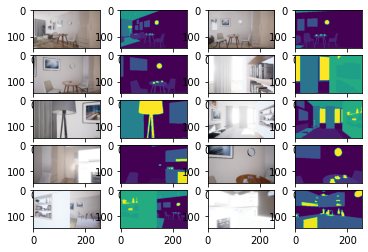

In [17]:
fig = plt.figure()

imgCount = 20
columns = 4
rows = 5
for i in range(len(testDataSet)):
    sample = testDataSet[i]
    ax = plt.subplot(rows, columns, 2*i + 1)
    plt.imshow(sample['image'].detach().numpy())

    ax = plt.subplot(rows, columns, 2*i + 2)
    plt.imshow(sample['mask'].detach().numpy())
    ids,cnts = np.unique(sample['mask'].detach().numpy().ravel().astype(int), return_counts=True)
    print(["{}:{}".format(airSimSemanticsConverter.getNyuNameForNyuId(idx), cnt) for idx,cnt in zip(ids,cnts)])
    
    if i == imgCount/2 - 1:
        plt.show()
        break

In [639]:
with open('distances.pkl', 'wb') as f:
    pickle.dump({"dist":distances, "valid": valid_points}, f)